<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 7
# Student 1: Ambarish Moharil
# Student 2: Kunal Geed
# Student 3: Mert Lostar

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
#%matplotlib inline
%pylab inline
torch.set_grad_enabled(True)  # Context-manager 


Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


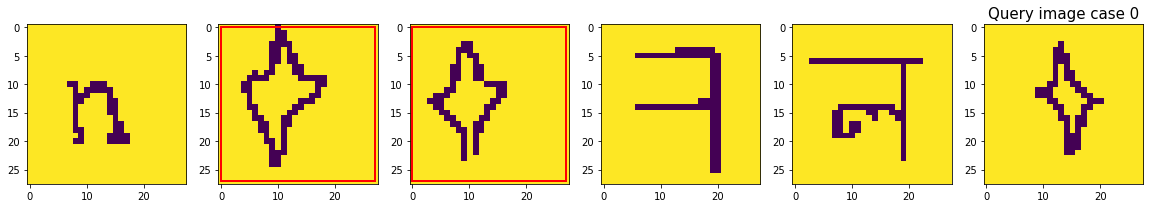

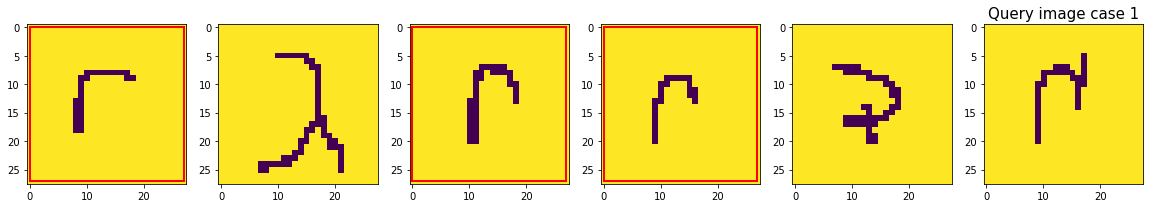

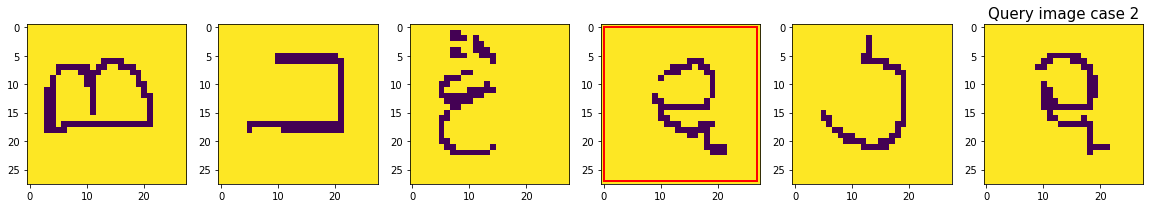

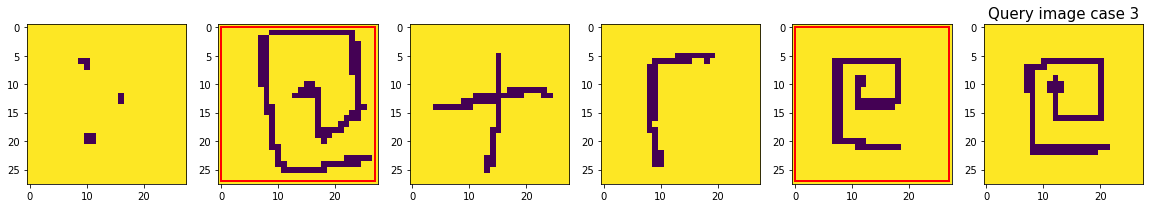

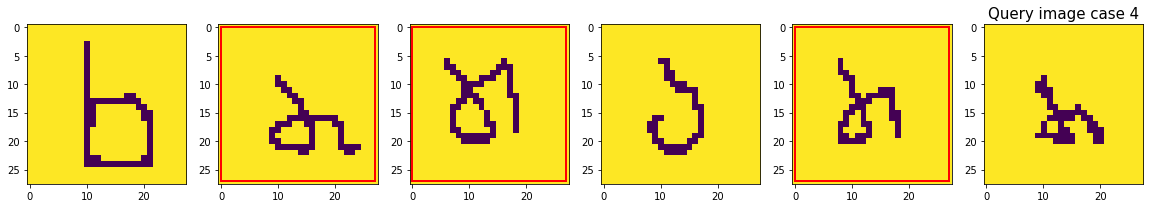

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [5]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



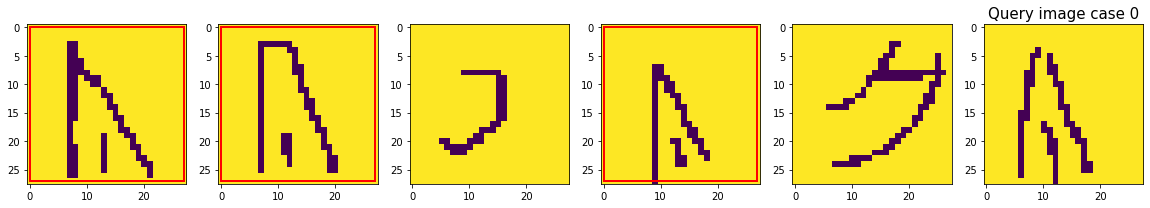

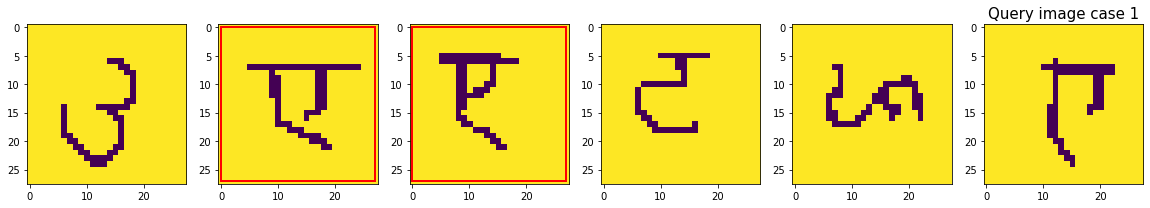

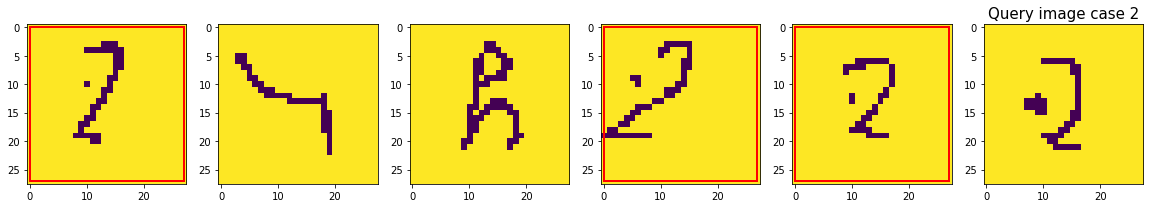

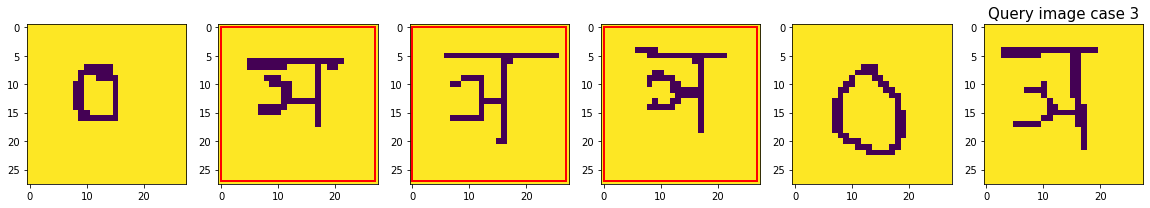

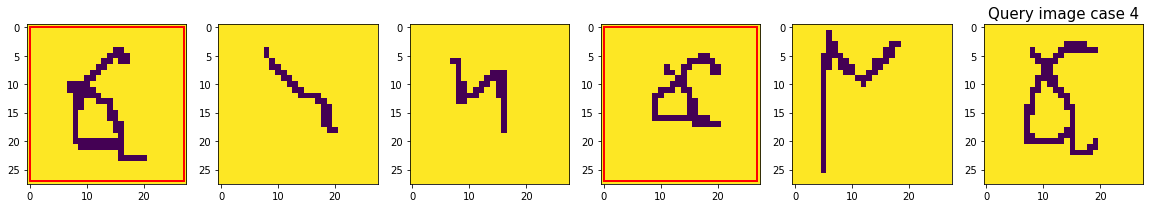

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
# transform = transforms.ToTensor()
train_dataset=MyDataset(train_data,train_label)
test_dataset=MyDataset(test_data,test_label)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

In [10]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
torch.cuda.is_available()

True

In [13]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# N 5-way one shot trials essentially 
    N <= len(test_set)

In [14]:
## Model Definition ##

### CNN Architecture (https://arxiv.org/pdf/1606.04080v2.pdf)

In [16]:
#ref :- https://github.com/fangpin/siamese-pytorch (Reimplementation of the Omniglot Paper https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

class Siamese_1(nn.Module):

    def __init__(self):
        super(Siamese_1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.liner = nn.Sequential(nn.Linear(384*3*3, 1024), nn.Sigmoid())
        self.out = nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid()) #Use with BCELoss
        #self.out = nn.Linear(1024, 1) #Use with BCEwithLogitLoss
        
    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        return out


In [17]:
## LOSS Definition ##

#Defining a Binary Cross-Entropy Loss (As Similarity is computed using a Sigmoid Function)

class BCELoss(nn.Module):
    
    def __init__(self):
        super(BCELoss, self).__init__()
        
    def forward(self, output, label):
        loss_fn = torch.nn.BCELoss()
        loss = loss_fn(output, label)
        return loss
    


In [18]:
#peek into the model architecture

def model_summary(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\n No of trainable parameters {temp:,} in the model')
    
model_summary(Siamese_1())

The model architecture:

 Siamese_Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3456, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

The model has 4,910,402 trainable parameters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


The model architecture:

 Siamese_1(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (liner): Sequential(
    (0): Linear(in_features=3456, out_features=1024, bias=True)
    (1): Sigmoid()
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

The model has 4,648,513 trainable parameters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [20]:
## Build Sample Selector ##

In [21]:
## Training ##

In [27]:
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))


def load_checkpoint(model, optimizer, path):
    save_path = path
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    val_acc = state_dict['val_acc']
    train_acc = state_dict['train_acc']
    train_loss = state_dict['train_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [30]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, labels in train_loader:
            support_set, queries = np.split(train_data, [5], axis=1)
            labels =  torch.tensor_split(labels, 5, dim=1)
            # Forward
            case_loss = 0.0
            cur_train_acc = 0.0
            cur_val_acc = 0.0
            for x in range(5):
                img1 = queries.to(device)
                x2 = support_set[:,x]
                img2 = x2.view(-1,1,28,28).to(device)
       
                output1 = model.forward(img1, img2)
                #Accuracy over a batch of 10
                curr_train_acc = torch.sum(torch.eq(labels[x].cuda(), torch.round(output1.cuda())))/10 #divide by the len of the batch_size

                #loss_fn = torch.nn.BCELoss()
                loss = criterion(output1, labels[x].float().to(device))
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                case_loss += loss.item()

            case_loss = case_loss/5
            cur_train_acc = curr_train_acc 
            #print("dhdh")
            #print(cur_train_acc)
            running_loss += case_loss
            running_train_acc += cur_train_acc
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_acc = running_train_acc/len(train_loader) 

        train_acc.append(avg_train_acc)
        
        val_running_loss = 0.0
        running_val_acc = 0.0 
        with torch.no_grad():
            model.eval()
            for val_data, labels in test_loader:
                support_set, queries = np.split(val_data, [5], axis=1)
                labels =  torch.tensor_split(labels, 5, dim=1)
                case_loss = 0.0
                curr_val_acc = 0
                for x in range(5):
                    img1 = queries.to(device)
                    #img2 = support_set.to(device)
                    x2 = support_set[:,x]
                    img2 = x2.view(-1,1,28,28).to(device)
                    #labels = labels[:,x].view(-1,1).to(device)
                    output2 = model.forward(img1, img2)

                    #Accuracy over a batch of 10
                    curr_val_acc = torch.sum(torch.eq(labels[x].cuda(), torch.round(output2.cuda())))/10 #divide by the len of the batch_size
               
                    loss = criterion(output2, labels[x].float().to(device))
                    case_loss += loss.item()

                case_loss = case_loss/5
                cur_val_acc = curr_val_acc/5 #divide by the no of images in the support set
                val_running_loss += case_loss
                running_val_acc += curr_val_acc

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        avg_val_acc = running_val_acc/len(val_loader)
        val_acc.append(avg_val_acc)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}, Train Acc : {:.4f}, Val Acc : {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss, avg_train_acc ,avg_val_acc ))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, avg_val_acc, avg_train_acc, avg_train_loss )
    
    print("Finished Training")  
    return train_losses, val_losses, train_acc, val_acc  

In [31]:
# actual training
import torch.optim as optim

SiameseNet1 = Siamese_1().cuda()


optimizer = optim.Adam(SiameseNet1.parameters(), lr = 3e-4)
num_epochs = 200
save_name = f'SiameseNet_BCE_w_acc.pt'
criterion = BCELoss()

obtained_train_loss, obtained_val_loss, obtained_train_acc, obtained_val_acc = train(SiameseNet1, 
                                                      train_loader, test_loader, criterion, num_epochs, save_name)

Starting epoch 1
Epoch [1/200],Train Loss: 0.4242, Valid Loss: 0.32452751, Train Acc : 0.7888, Val Acc : 0.85700035
Model Saved to ==> SiameseNet_BCE_w_acc.pt
Starting epoch 2
Epoch [2/200],Train Loss: 0.2444, Valid Loss: 0.25315111, Train Acc : 0.9066, Val Acc : 0.89800042
Model Saved to ==> SiameseNet_BCE_w_acc.pt
Starting epoch 3
Epoch [3/200],Train Loss: 0.1542, Valid Loss: 0.24564786, Train Acc : 0.9471, Val Acc : 0.90500045
Model Saved to ==> SiameseNet_BCE_w_acc.pt
Starting epoch 4
Epoch [4/200],Train Loss: 0.0875, Valid Loss: 0.25548841, Train Acc : 0.9745, Val Acc : 0.89600033
Starting epoch 5
Epoch [5/200],Train Loss: 0.0467, Valid Loss: 0.28396550, Train Acc : 0.9883, Val Acc : 0.90100026
Starting epoch 6
Epoch [6/200],Train Loss: 0.0330, Valid Loss: 0.28020900, Train Acc : 0.9919, Val Acc : 0.89900023
Starting epoch 7
Epoch [7/200],Train Loss: 0.0266, Valid Loss: 0.31351651, Train Acc : 0.9934, Val Acc : 0.91300029
Starting epoch 8
Epoch [8/200],Train Loss: 0.0227, Valid Lo

In [49]:
## Evaluation ##

In [43]:
def convert_list_of_tensors(list_input):
  converted_tensor_list = []
  for tensor in list_input:
    converted_tensor_list.append(tensor.to('cpu'))
  return converted_tensor_list

obtained_train_acc = convert_list_of_tensors(obtained_train_acc)
obtained_val_acc = convert_list_of_tensors(obtained_val_acc)

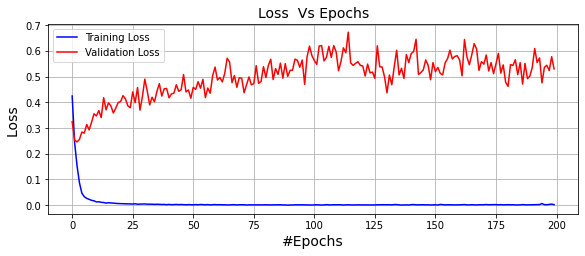

######################################################################


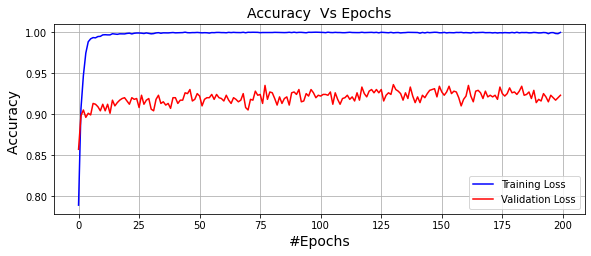

In [60]:
fig = plt.gcf()
fig.set_size_inches(9.5, 3.5)
plt.plot(range(0,200),obtained_train_loss, label = "Training Loss", color = "blue")
plt.plot(range(0,200),obtained_val_loss, label = "Validation Loss", color = "red")
plt.title('Loss  Vs Epochs', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Loss.png')
fig = plt.gcf()
print("######################################################################")
fig.set_size_inches(9.5, 3.5)
plt.plot(range(0,200),obtained_train_acc, label = "Training Loss", color = "blue")
plt.plot(range(0,200),obtained_val_acc, label = "Validation Loss", color = "red")
plt.title('Accuracy  Vs Epochs', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Accuracy ', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Accuracy.png')

In [ ]:
#Plot the query_image - support set images and the computed similarity between the tw0. (Do this for a batch)